Performing text classifications without deep learning. But I will still use pretrained vectors. 

## Getting the dataset

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import required libraries

In [0]:
!pip install --upgrade --quiet gspread

In [0]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

In [0]:
cd /content/drive/My Drive/ML Text classifier

/content/drive/My Drive/ML Text classifier


In [0]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
import nltk
from gensim.models import Word2Vec, KeyedVectors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneOut

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

from sklearn import svm
from sklearn.metrics import accuracy_score,confusion_matrix

from sklearn.feature_selection import RFE
%matplotlib inline

In [0]:
worksheet_annotate = gc.open('PTSD_data').worksheet('Annotations')
worksheet_text = gc.open('PTSD_data').worksheet('PTSD_data')

# get_all_values gives a list of rows.
rows_annotate = worksheet_annotate.get_all_values()
rows_text = worksheet_text.get_all_values()


import pandas as pd



Remove the first 3 rows and set the fourth row as the header

In [0]:
sheet_text = pd.DataFrame.from_records(rows_text)
header = sheet_text.iloc[3]
sheet_text = sheet_text.iloc[4:]
sheet_text.columns = header

sheet_text.head()

3,transcript_id,character,text,Keywords / Significant sentences,A1,B1,B2,B3,B4,B5,C1,C2,D1,D2,D3,D4,D5,D6,D7,E1,E2,E3,E4,E5,E6,F1,G1
4,PTSD_file_1,CLIENT,Remind me never to go to a work meeting with a...,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,PTSD_file_1,THERAPIST,Those darn women.,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,PTSD_file_1,CLIENT,Damn women. Our boss is she's just a shut the ...,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,PTSD_file_1,THERAPIST,It's not that comfortable.,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,PTSD_file_1,CLIENT,What's that?,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Remove the first row and set it as the header

In [0]:
sheet_annotate = pd.DataFrame.from_records(rows_annotate)
header = sheet_annotate.iloc[1]
sheet_annotate = sheet_annotate.iloc[2:]
sheet_annotate.columns = header


sheet_annotate.drop([14,15,16,29,30,31,32,33,43,44,49,48],inplace=True)
sheet_annotate.tail()

1,Session_id,Scorer,A,B,C,D,E,G
41,PTSD_file_40,Abby,1,1,0,1,0,1
42,PTSD_file_41,Abby,0,0,0,0,0,0
45,PTSD_file_44,Colton,0,0,0,1,0,0
46,PTSD_file_45,Colton,0,0,0,0,0,0
47,PTSD_file_46,Albert,1,0,1,0,0,0


Extract labels and sum to get calculated PTSD Risk

In [0]:
sheet_annotate.iloc[:,2:] = sheet_annotate.iloc[:,2:].astype('int32')
labels = sheet_annotate.iloc[:,2:].sum(axis = 1, skipna = True) /6

Extract data by PTSD file name

In [0]:
Session_id = sheet_annotate['Session_id'][:46]

clients_texts = []
for i in Session_id:
  
  #get each client text and combine them into a single array
  client_text = sheet_text.loc[(sheet_text.transcript_id == i)&(sheet_text.character == 'CLIENT')].text.values.ravel()
  
  #append to list
  clients_texts.append(client_text)
  


In [0]:
len(clients_texts)

36

Make it a block of text for each client rather than separate statements: to ease processing

In [0]:
clients_texts_block = []
for i in clients_texts:
  line=""
  for j in i:
    line += j 
  clients_texts_block.append(line)



clients_texts_block = np.array(clients_texts_block)

len(clients_texts_block)

36

## Clean Up

Getting tools for cleaning up dataset

In [0]:

nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
import re
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Cleaning up the data

In [0]:

def clean_up(X):
  X_clean =np.empty(X.shape[0],dtype=object)
  
  
  index= 0
  for line in X:
   
    #removes text in brackets like inaudible
    line = re.sub("[\(\[].*?[\)\]]", "", line)
    
    # Tokenize the string into words
    tokens = word_tokenize(line)

    # Remove non-alphabetic tokens, such as punctuation
    words = [word.lower() for word in tokens if word.isalpha()]

    # Filter out stopwords
    
    X_clean[index]  = [word for word in words if not word in stop_words]
    
    index+=1
    
  return X_clean
    
  



In [0]:
clients_texts_clean = clean_up(clients_texts_block)


In [0]:
cd ..

/content/drive/My Drive


Using  word embeddings on dataset to vectorize text data. Did not want to use tfidf because the dataset is so small and getting the same words in the same class that signify PTSD risk might be difficult.

Could be wrong though

In [0]:

#my personally stored trained word embeddings

model = KeyedVectors.load("word_vectors.kv")
model['word'].shape

(300,)


Function to reduce the number of embeddings for each client, it performs an average of each row of word embeddings

In [0]:
def document_vector(model, doc):
    # remove out-of-vocabulary words
    
    doc = [word for word in doc if word in model.vocab]
    if doc:
      return np.mean(model[doc], axis=0)
  


In [0]:
clients_texts_embed = []
for i in clients_texts_clean:
  clients_texts_embed.append(document_vector(model,i))
  
clients_texts_embed=np.array(clients_texts_embed)


In [0]:
clients_texts_embed.shape

(36, 300)

In [0]:
X = clients_texts_embed
y = labels.values

### Visualization

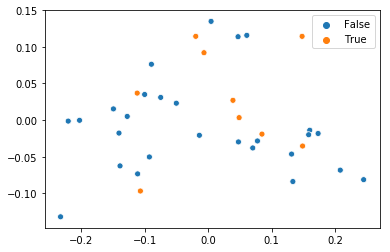

In [0]:
import seaborn as sns
from sklearn.decomposition import PCA


pca = PCA(n_components=2)
pca_components = pca.fit_transform(X)  

xs = pca_components[:,0]
ys = pca_components[:,1]

sns.scatterplot(xs,ys,hue=y>0.5) 
#True - presence of PTSD risk

Classes don't seem separable

## Training

### Logistic Regression

In [0]:
#Remove warnings
import warnings
warnings.filterwarnings('ignore')

1. Used Stratify kfold to evaluate overfitting while ensuring representation of all classes in all folds
2. Set class_weight to balanced to give higher weight to underrepresented class
3.Used recall score and accuracy score to evaluate accuracy on each fold


In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score,confusion_matrix,accuracy_score
from sklearn.model_selection import StratifiedKFold

#stratified kfold
skf = StratifiedKFold(n_splits=5)

#initialize list to store the confusion matrices                      
cm = []
print("Train Accuracy \t\t\t\t\t Test Accuracy")
print("[accuracy_score,recall_score] \t\t [accuracy_score,recall_score]\n")
for train_index, test_index in skf.split(X, y):
  
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  
  #seemingly the best hyperparameters
  clf = LogisticRegression(random_state=0, C=1,solver='liblinear',class_weight="balanced").fit(X_train, y_train)
                     
                      
  pred_train = clf.predict(X_train)
  pred_test = clf.predict(X_test)

  train_acc = [accuracy_score(y_train,pred_train),recall_score(y_train,pred_train)]
  test_acc = [accuracy_score(y_test,pred_test),recall_score(y_test,pred_test)]
  
  cm.append(confusion_matrix(y_test,pred_test))

  print(train_acc,"\t\t",test_acc)

Train Accuracy 					 Test Accuracy
[accuracy_score,recall_score] 		 [accuracy_score,recall_score]

[0.6785714285714286, 1.0] 		 [0.5, 1.0]
[0.6785714285714286, 1.0] 		 [0.375, 0.5]
[0.5862068965517241, 1.0] 		 [0.5714285714285714, 0.5]
[0.9310344827586207, 1.0] 		 [0.42857142857142855, 0.0]
[0.6666666666666666, 1.0] 		 [0.8333333333333334, 1.0]


In [0]:
#for test data only
for i in range(len(cm)):
  print("Test Fold",i)
  print(cm[i])

Test Fold 0
[[2 4]
 [0 2]]
Test Fold 1
[[2 4]
 [1 1]]
Test Fold 2
[[3 2]
 [1 1]]
Test Fold 3
[[3 2]
 [2 0]]
Test Fold 4
[[4 1]
 [0 1]]


### SVM

In [0]:
from sklearn.svm import LinearSVC


#stratified kfold
skf = StratifiedKFold(n_splits=5)

#initialize list t#seemingly the best hyperparameters#seemingly the best hyperparameterso store the confusion matrices 
cm = []
print("Train Accuracy \t\t\t\t\t Test Accuracy")
print("[accuracy_score,recall_score] \t\t [accuracy_score,recall_score]\n")

for train_index, test_index in skf.split(X, y):
  
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  
  #seemingly the best hyperparameters
  clf = LinearSVC(C=1,class_weight="balanced").fit(X_train, y_train)
  pred_train = clf.predict(X_train)
  pred_test = clf.predict(X_test)

  train_acc = [accuracy_score(y_train,pred_train),recall_score(y_train,pred_train)]
  test_acc = [accuracy_score(y_test,pred_test),recall_score(y_test,pred_test)]
  
  cm.append(confusion_matrix(y_test,pred_test))

  print(train_acc,"\t\t",test_acc)

Train Accuracy 					 Test Accuracy
[accuracy_score,recall_score] 		 [accuracy_score,recall_score]

[0.6785714285714286, 1.0] 		 [0.75, 1.0]
[0.75, 1.0] 		 [0.5, 0.5]
[0.9310344827586207, 1.0] 		 [0.42857142857142855, 0.0]
[0.9310344827586207, 1.0] 		 [0.42857142857142855, 0.0]
[0.9, 1.0] 		 [0.8333333333333334, 1.0]


In [0]:
#for test data only
for i in range(len(cm)):
  print("Test Fold",i)
  print(cm[i])

Test Fold 0
[[4 2]
 [0 2]]
Test Fold 1
[[3 3]
 [1 1]]
Test Fold 2
[[3 2]
 [2 0]]
Test Fold 3
[[3 2]
 [2 0]]
Test Fold 4
[[4 1]
 [0 1]]
